In [0]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, hour, dayofweek, month, count, avg, sum as sum_col
from pyspark.ml.feature import StringIndexer, VectorAssembler
from pyspark.ml.regression import LinearRegression
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import RegressionEvaluator, BinaryClassificationEvaluator
from pyspark.ml import Pipeline
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import matplotlib.pyplot as plt
import mlflow
import mlflow.spark

# Create Spark session
spark = SparkSession.builder \
    .appName("SocialMediaAnalysis") \
    .getOrCreate()

## Downloading the Dataset

In [0]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, hour, dayofweek, month, from_unixtime, to_timestamp, when

# Create Spark session
spark = SparkSession.builder.appName("RedditEngagementAnalysis").getOrCreate()

# Load Reddit post data
# 📥 Load Reddit Posts CSV into Spark DataFrame
df_post_reddit = spark.read.format("csv") \
    .option("header", "true") \
    .option("multiLine", True) \
    .option("escape", "\"") \
    .load("dbfs:/FileStore/shared_uploads/mwa47@mail.aub.edu/reddit_data/reddit_posts_df.csv")
    
df_comments_reddit = spark.read.format("csv") \
    .option("header", "true") \
    .option("multiLine", True) \
    .option("escape", "\"") \
    .load("dbfs:/FileStore/shared_uploads/mwa47@mail.aub.edu/reddit_data/reddit_post_comments.csv")

# Load Twitter post data
df_tweet = spark.read.format("csv") \
    .option("header", "true") \
    .option("multiLine", True) \
    .option("escape", "\"") \
    .load("dbfs:/FileStore/shared_uploads/mwa47@mail.aub.edu/twitter_data/twitter_data_science_tweets.csv")

df_users_twitter = spark.read.format("csv") \
    .option("header", "true") \
    .option("multiLine", True) \
    .option("escape", "\"") \
    .load("dbfs:/FileStore/shared_uploads/mwa47@mail.aub.edu/twitter_data/twitter_data_science_users.csv")

In [0]:
print(df_post_reddit.show(5))

+---+-------+--------------------+--------------------+---------------+------------+-----+------------+------------+
|_c0|post_id|               title|                text|         author| created_utc|score|num_comments|upvote_ratio|
+---+-------+--------------------+--------------------+---------------+------------+-----+------------+------------+
|  0|1jyq1tk|Weekly Entering &...| \n\nWelcome to t...|  AutoModerator|1744603309.0|    9|          43|        0.91|
|  1|1i5inrb|Weekly Entering &...| \n\nWelcome to t...|  AutoModerator|1737349304.0|   13|          46|        0.94|
|  2|1k26920|How do you go abo...|I’ve been prepari...|Lamp_Shade_Head|1744986429.0|   65|          36|        0.93|
|  3|1k26kp3|What’s your 2025 ...|Curious how other...|        Zuricho|1744987285.0|   41|          16|        0.88|
|  4|1k2a8t6|Forecasting: Prin...|                null|          Sampo|1744996521.0|   10|           1|        0.92|
+---+-------+--------------------+--------------------+---------

In [0]:
print(df_comments_reddit.show(5))

+----------+-------+--------------------+--------------------+-----+------------+
|comment_id|post_id|              author|                text|score| created_utc|
+----------+-------+--------------------+--------------------+-----+------------+
|   mn0k755|1jyq1tk|            Norse_af|Here is the roadm...|    2|1744607433.0|
|   mn2syxi|1jyq1tk|  Formal-Degree-1578|Hi everyone, I’m ...|    2|1744645314.0|
|   mndey84|1jyq1tk|              tejjm9|Hi guys, I have w...|    2|1744788459.0|
|   mn0jtkc|1jyq1tk|            Norse_af|Starting a Master...|    1|1744607230.0|
|   mn0vcwx|1jyq1tk|Complete-Sandwich564|\nNew here, this ...|    1|1744613941.0|
+----------+-------+--------------------+--------------------+-----+------------+
only showing top 5 rows

None


## Data Preparation

In this part, we will prepare our data to be ready for machine learning. This will include the following steps:
- **Feature Engineering**:  
  We will create 3 new time-based features — `hour`, `month`, and `day_of_week` — extracted from the `created_utc` timestamp column. These features will help us gain insights into when each post was created, and how time-related patterns may influence engagement. Also `engagement_metric` was created based on the score and number of comments
- **Data Joining**:  
  We will join the Reddit comments dataset with the posts dataset using the `post_id` column. This will allow us to enrich each Reddit post with aggregated comment-level features such as the average comment score and total number of comments, enabling a more informative feature set for our predictive model.
- **Data Cleaning**:  
  We will cast all numerical features and the target variable to the appropriate data types (e.g., `double`) and remove any rows with missing values in key columns. This ensures that the data fed into the machine learning models is clean, consistent, and ready for vector assembly.

In [0]:
# 💡 Create an engagement metric: score + num_comments
df = df_post_reddit.withColumn("engagement_metric", col("score") + col("num_comments"))

# Drop missing engagement rows (shouldn't happen, but just in case)
df = df.dropna(subset=["engagement_metric"])
df = df.withColumn("engagement_metric", col("engagement_metric").cast("double"))

# Convert created_utc (epoch) into proper timestamp
df = df.withColumn("timestamp", to_timestamp(from_unixtime(col("created_utc"))))

# Extract time features
df = df.withColumn("hour", hour(col("timestamp")))
df = df.withColumn("day_of_week", dayofweek(col("timestamp")))
df = df.withColumn("month", month(col("timestamp")))

# Print schema and preview
df.printSchema()
df.select("post_id", "engagement_metric", "timestamp", "hour", "day_of_week").show(5)

root
 |-- _c0: string (nullable = true)
 |-- post_id: string (nullable = true)
 |-- title: string (nullable = true)
 |-- text: string (nullable = true)
 |-- author: string (nullable = true)
 |-- created_utc: string (nullable = true)
 |-- score: string (nullable = true)
 |-- num_comments: string (nullable = true)
 |-- upvote_ratio: string (nullable = true)
 |-- engagement_metric: double (nullable = true)
 |-- timestamp: timestamp (nullable = true)
 |-- hour: integer (nullable = true)
 |-- day_of_week: integer (nullable = true)
 |-- month: integer (nullable = true)

+-------+-----------------+-------------------+----+-----------+
|post_id|engagement_metric|          timestamp|hour|day_of_week|
+-------+-----------------+-------------------+----+-----------+
|1jyq1tk|             52.0|2025-04-14 04:01:49|   4|          2|
|1i5inrb|             59.0|2025-01-20 05:01:44|   5|          2|
|1k26920|            101.0|2025-04-18 14:27:09|  14|          6|
|1k26kp3|             57.0|2025-04-18 1

In [0]:
# Joining df_comments_reddit with the posts dataset
from pyspark.sql.functions import avg, count

df_comments_agg = df_comments_reddit.groupBy("post_id").agg(
    avg("score").alias("avg_comment_score"),
    count("*").alias("comment_count")
)

df_combined = df.join(df_comments_agg, on="post_id", how="left")

print(df_combined.show(5))

+-------+---+--------------------+--------------------+---------------+------------+-----+------------+------------+-----------------+-------------------+----+-----------+-----+------------------+-------------+
|post_id|_c0|               title|                text|         author| created_utc|score|num_comments|upvote_ratio|engagement_metric|          timestamp|hour|day_of_week|month| avg_comment_score|comment_count|
+-------+---+--------------------+--------------------+---------------+------------+-----+------------+------------+-----------------+-------------------+----+-----------+-----+------------------+-------------+
|1jyq1tk|  0|Weekly Entering &...| \n\nWelcome to t...|  AutoModerator|1744603309.0|    9|          43|        0.91|             52.0|2025-04-14 04:01:49|   4|          2|    4|1.1666666666666667|           18|
|1i5inrb|  1|Weekly Entering &...| \n\nWelcome to t...|  AutoModerator|1737349304.0|   13|          46|        0.94|             59.0|2025-01-20 05:01:44|  

In [0]:
print(df_combined.columns)

['post_id', '_c0', 'title', 'text', 'author', 'created_utc', 'score', 'num_comments', 'upvote_ratio', 'engagement_metric', 'timestamp', 'hour', 'day_of_week', 'month', 'avg_comment_score', 'comment_count']


In [0]:
num_rows = df_combined.count()
num_cols = len(df_combined.columns)

print(f"📊 Shape of df_combined: ({num_rows}, {num_cols})")

📊 Shape of df_combined: (50, 16)


In [0]:
# Casting all numerical features and the target variable to the appropriate data types (e.g., double)

numeric_cols = ['hour', 'day_of_week', 'month', "num_comments", "upvote_ratio", 'avg_comment_score', 'comment_count', "engagement_metric"]

for colname in numeric_cols:
    df_combined = df_combined.withColumn(colname, col(colname).cast("double"))

In [0]:
# Checking the number of missing values

from pyspark.sql.functions import col, sum as _sum
import pandas as pd

# Compute null counts
null_counts = df_combined.select([
    _sum(col(c).isNull().cast("int")).alias(c) for c in df_combined.columns
]).toPandas().T.reset_index()

# Rename columns and sort
null_counts.columns = ["column", "null_count"]
null_counts = null_counts[null_counts["null_count"] > 0].sort_values(by="null_count", ascending=False)

# Display as pretty table
print("🧼 Null Count Per Column:")
print(null_counts.to_string(index=False))

🧼 Null Count Per Column:
           column  null_count
             text           4
avg_comment_score           2
    comment_count           2


In [0]:
# Dropping all missing values

df_cleaned = df_combined.select(numeric_cols).dropna()

## EDA
In this part, we will perform exploratory data analysis to better understand the relationships between our features and the target variable. This will include the following:
- **Descriptive Statistics**:  
  Display summary statistics (mean, stddev, min, max) for all numerical features to get an overview of the data distribution.
- **Distribution Analysis**:  
  Plot histograms for all numerical features to observe their distributions and detect skewness, outliers, or imbalanced ranges.
- **Feature vs. Target Relationships**:  
  Generate scatterplots between each numerical feature and the target variable (`engagement_metric`) to visually explore potential correlations or nonlinear patterns.
- **Correlation Matrix**:  
  Display a heatmap of the Pearson correlation coefficients between numerical features to identify strongly related variables.


In [0]:
#

desc_pd = df_cleaned[numeric_cols].describe().toPandas()
# Expand display settings
pd.set_option('display.max_columns', None)  # show all columns
pd.set_option('display.width', None)        # don't wrap lines
pd.set_option('display.max_colwidth', None) # show full column values

# Print full describe DataFrame
print(desc_pd)

  summary                hour         day_of_week               month  \
0   count                  48                  48                  48   
1    mean  11.520833333333334   4.416666666666667              3.9375   
2  stddev   7.336848367768767  1.8431394739865388  0.4330127018922193   
3     min                 0.0                 1.0                 1.0   
4     max                23.0                 7.0                 4.0   

         num_comments        upvote_ratio  avg_comment_score  \
0                  48                  48                 48   
1  29.645833333333332  0.7966666666666669   7.04411006339091   
2  30.316409139615587   0.180852982885104  5.844957283368673   
3                 1.0                0.31                1.0   
4               155.0                 1.0               27.8   

        comment_count   engagement_metric  
0                  48                  48  
1  15.645833333333334  109.77083333333333  
2  14.431775791019952  160.56459422437973  


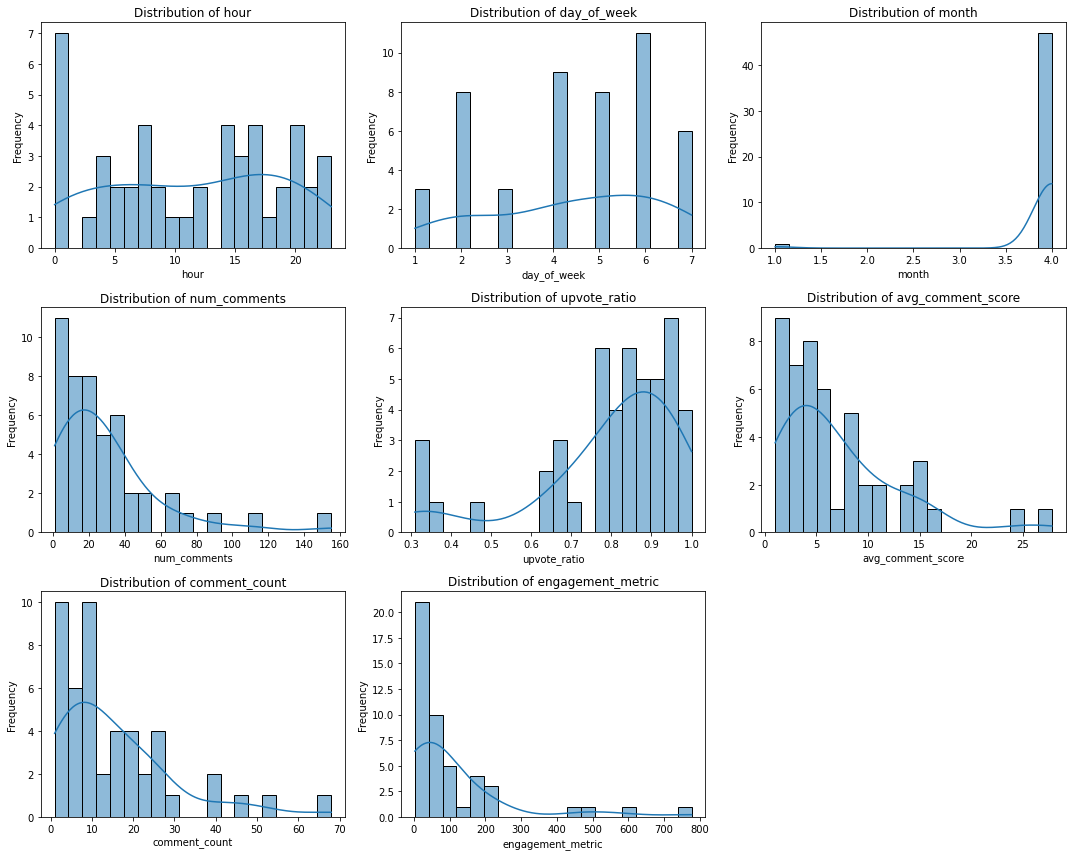

In [0]:
import matplotlib.pyplot as plt
import seaborn as sns
import math

# Convert to pandas
df_numerical = df_cleaned.select(numeric_cols).dropna().toPandas()

# Dynamically calculate number of subplots
n = len(df_numerical.columns)
cols = 3
rows = math.ceil(n / cols)

# Plot
plt.figure(figsize=(5 * cols, 4 * rows))

for i, col in enumerate(df_numerical.columns, 1):
    plt.subplot(rows, cols, i)
    sns.histplot(df_numerical[col], bins=20, kde=True)
    plt.title(f"Distribution of {col}")
    plt.xlabel(col)
    plt.ylabel("Frequency")

plt.tight_layout()
plt.show()

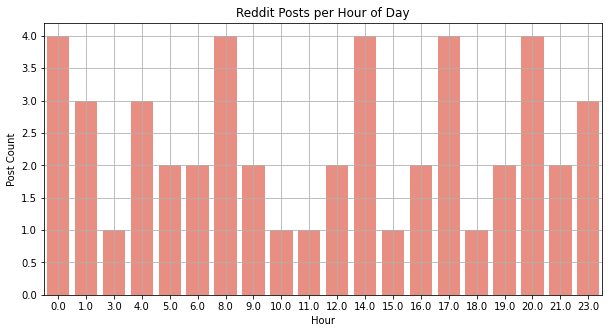

In [0]:
# Post Count by Hour
from pyspark.sql.functions import hour, from_unixtime

# Group and convert to pandas
posts_per_hour = df_cleaned.groupBy("hour").count().orderBy("hour").toPandas()

# Now plot it
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 5))
sns.barplot(data=posts_per_hour, x="hour", y="count", color='salmon')
plt.title("Reddit Posts per Hour of Day")
plt.xlabel("Hour")
plt.ylabel("Post Count")
plt.grid(True)
plt.show()

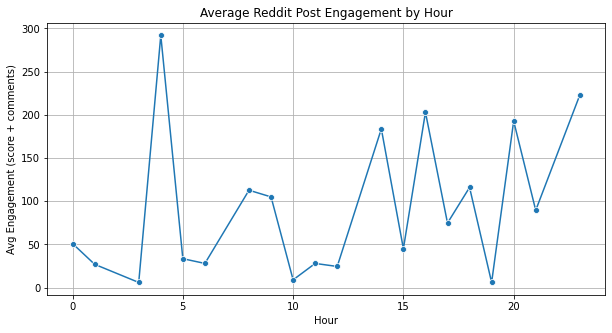

In [0]:
# Average Engagement by Hour
hourly_engagement = df_cleaned.groupBy("hour").agg(
    avg("engagement_metric").alias("avg_engagement")
).orderBy("hour").toPandas()

plt.figure(figsize=(10, 5))
sns.lineplot(data=hourly_engagement, x="hour", y="avg_engagement", marker="o")
plt.title("Average Reddit Post Engagement by Hour")
plt.xlabel("Hour")
plt.ylabel("Avg Engagement (score + comments)")
plt.grid(True)
plt.show()

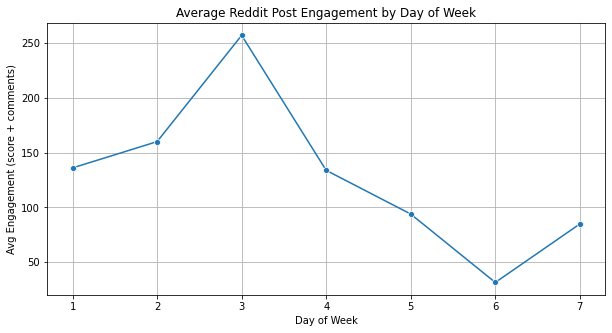

In [0]:
# Average Engagement by Day of Week
day_of_week = df_cleaned.groupBy("day_of_week").agg(
    avg("engagement_metric").alias("avg_engagement")
).orderBy("day_of_week").toPandas()

plt.figure(figsize=(10, 5))
sns.lineplot(data=day_of_week, x="day_of_week", y="avg_engagement", marker="o")
plt.title("Average Reddit Post Engagement by Day of Week")
plt.xlabel("Day of Week")
plt.ylabel("Avg Engagement (score + comments)")
plt.grid(True)
plt.show()

/databricks/python/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 128338 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/databricks/python/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:203: RuntimeWarning: Glyph 128338 missing from current font.
  font.set_text(s, 0, flags=flags)


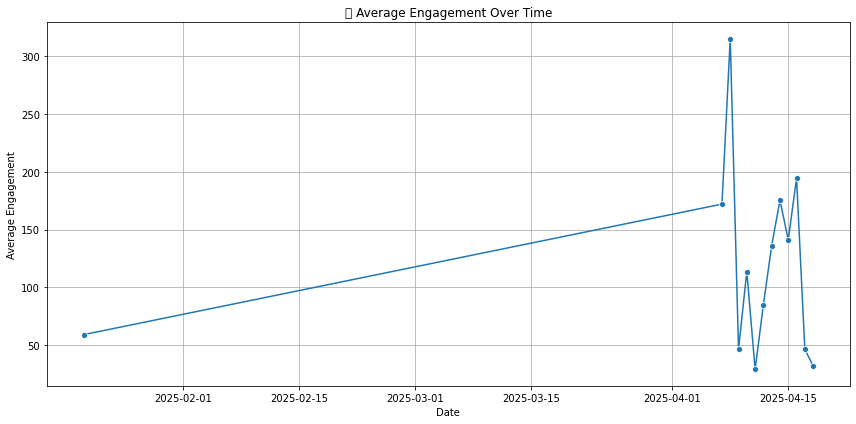

In [0]:
# ✅ Step 0: Imports
from pyspark.sql.functions import from_unixtime, to_timestamp, date_trunc, col, avg

# ✅ Step 1: Convert UNIX timestamp to proper Spark timestamp
df_combined = df_combined.withColumn(
    "timestamp", to_timestamp(from_unixtime(col("created_utc").cast("long")))
)

# ✅ Step 2: Truncate timestamp to daily granularity
df_time = df_combined.withColumn("datetime", date_trunc("day", col("timestamp")))

# ✅ Step 3: Ensure engagement_metric is a numeric column
df_time = df_time.withColumn("engagement_metric", col("engagement_metric").cast("double"))

# ✅ Step 4: Aggregate average engagement by day
df_time_agg = df_time.groupBy("datetime").agg(
    avg("engagement_metric").alias("avg_engagement")
).orderBy("datetime")

# ✅ Step 5: Convert to Pandas for plotting
df_time_pd = df_time_agg.dropna().toPandas()
df_time_pd["datetime"] = pd.to_datetime(df_time_pd["datetime"])

# ✅ Step 6: Plot the time-series chart
plt.figure(figsize=(12, 6))
sns.lineplot(data=df_time_pd, x="datetime", y="avg_engagement", marker='o')
plt.title("🕒 Average Engagement Over Time")
plt.xlabel("Date")
plt.ylabel("Average Engagement")
plt.grid(True)
plt.tight_layout()
plt.show()

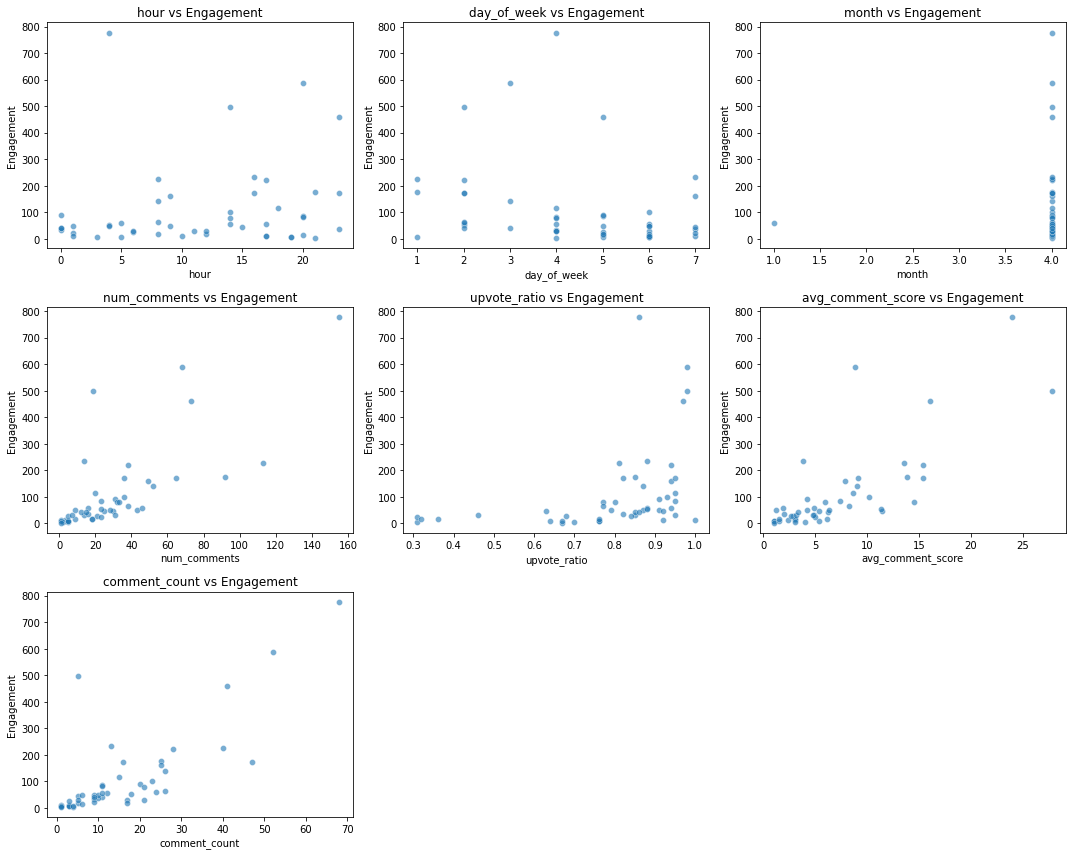

In [0]:
import matplotlib.pyplot as plt
import seaborn as sns
import math

# Exclude target variable
features_to_plot = [col for col in numeric_cols if col != "engagement_metric"]

# Dynamically compute grid size
n = len(features_to_plot)
cols = 3
rows = math.ceil(n / cols)

plt.figure(figsize=(5 * cols, 4 * rows))

for i, col in enumerate(features_to_plot, 1):
    plt.subplot(rows, cols, i)
    sns.scatterplot(data=df_numerical, x=col, y="engagement_metric", alpha=0.6)
    plt.title(f"{col} vs Engagement")
    plt.xlabel(col)
    plt.ylabel("Engagement")

plt.tight_layout()
plt.show()

/databricks/spark/python/pyspark/sql/context.py:134: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


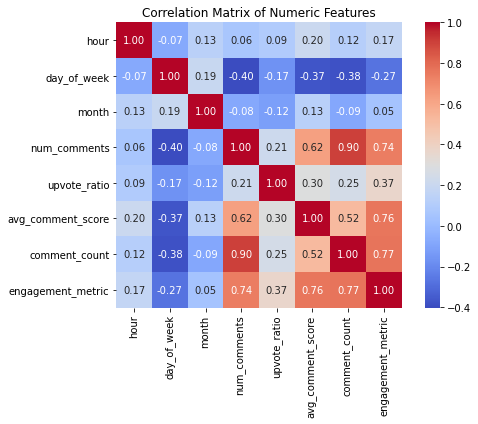

In [0]:
from pyspark.sql.functions import col
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.stat import Correlation
import matplotlib.pyplot as plt

# Recast all numeric columns to double
for colname in numeric_cols:
    df_cleaned = df_cleaned.withColumn(colname, col(colname).cast("double"))

# Assemble features into vector
assembler = VectorAssembler(inputCols=numeric_cols, outputCol="features_corr")
df_vec = assembler.transform(df_cleaned).select("features_corr")

# Compute correlation matrix
correlation_matrix = Correlation.corr(df_vec, "features_corr", method="pearson").head()[0]

# Convert to Pandas DataFrame
corr_array = correlation_matrix.toArray()
corr_df = pd.DataFrame(corr_array, columns=numeric_cols, index=numeric_cols)

# Plot heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(corr_df, annot=True, cmap="coolwarm", fmt=".2f", square=True)
plt.title("Correlation Matrix of Numeric Features")
plt.tight_layout()
plt.show()


## Machine Learning Pipeline

In this section, we build and evaluate two different machine learning models to predict the engagement level of Reddit posts. The entire pipeline includes feature assembly, model training, and evaluation. The models used are:
- **Linear Regression**:  
  A simple and interpretable model that assumes a linear relationship between the input features and the target variable (`engagement_metric`). We applied **MinMaxScaler** before fitting this model to normalize feature values. This model provides valuable insights into how each feature linearly contributes to the target, and we visualized its coefficients and statistical significance (p-values).
- **Random Forest Regressor**:  
  A powerful ensemble model that builds multiple decision trees and averages their predictions. It can capture complex, nonlinear interactions between features without requiring scaling. We used this model without normalization, and explored **feature importances** to understand which variables had the strongest impact on engagement.  

After training both models, we evaluated them using **Root Mean Squared Error (RMSE)** and tracked their performance using **MLflow** for comparison. This allows us to assess trade-offs between interpretability and predictive accuracy.

In [0]:
from pyspark.sql.functions import col
from pyspark.ml.feature import VectorAssembler, MinMaxScaler
from pyspark.ml.regression import LinearRegression
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import RegressionEvaluator
import mlflow
import mlflow.spark

# ✅ Define your selected features
feature_cols = ['hour', 'day_of_week', 'month', 'num_comments', 'upvote_ratio', 'avg_comment_score']

# ✅ Ensure all selected features and the label are of type double
for colname in feature_cols + ['engagement_metric']:
    df_cleaned = df_cleaned.withColumn(colname, col(colname).cast("double"))

# ✅ Assemble the features
assembler = VectorAssembler(inputCols=feature_cols, outputCol="features")

# ✅ Apply MinMaxScaler
scaler = MinMaxScaler(inputCol="features", outputCol="scaled_features")

# ✅ Define the linear regression model
lr = LinearRegression(featuresCol="scaled_features", labelCol="engagement_metric")

# ✅ Build the pipeline
pipeline = Pipeline(stages=[assembler, scaler, lr])

# ✅ Split into training and testing sets
train_data, test_data = df_cleaned.randomSplit([0.8, 0.2], seed=42)

# ✅ MLflow tracking
if mlflow.active_run():
    mlflow.end_run()
mlflow.start_run(run_name="Engagement_Prediction_MinMax_Scaled")

# ✅ Train the model
model = pipeline.fit(train_data)

# ✅ Predict on test data
predictions = model.transform(test_data)

# ✅ Evaluate the model
evaluator = RegressionEvaluator(
    labelCol="engagement_metric",
    predictionCol="prediction",
    metricName="rmse"
)
rmse = evaluator.evaluate(predictions)

# ✅ Log with MLflow
mlflow.log_param("model", "LinearRegression")
mlflow.log_param("features_used", ", ".join(feature_cols))
mlflow.log_metric("rmse", rmse)
mlflow.spark.log_model(model, "model")

# ✅ End the MLflow run
mlflow.end_run()

print(f"✅ Final RMSE (Scaled): {rmse:.2f}")

✅ Final RMSE (Scaled): 55.17


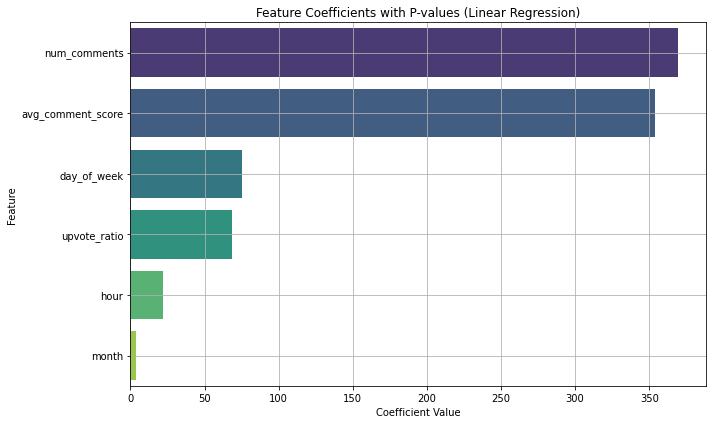

In [0]:
# Extract trained linear model and assembler
lr_model = model.stages[-1]       # LinearRegression
assembler_model = model.stages[0] # VectorAssembler
features = assembler_model.getInputCols()

# Get coefficients and p-values
summary = lr_model.summary
coefficients = lr_model.coefficients
p_values = summary.pValues[1:]  # Remove intercept

# Build DataFrame
coeff_df = pd.DataFrame({
    "feature": features,
    "coefficient": coefficients,
    "p_value": p_values
}).sort_values("coefficient", key=abs, ascending=False)

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(data=coeff_df, x="coefficient", y="feature", palette="viridis")
plt.title("Feature Coefficients with P-values (Linear Regression)")
plt.xlabel("Coefficient Value")
plt.ylabel("Feature")
plt.grid(True)
plt.tight_layout()
plt.show()

In [0]:
from pyspark.sql.functions import col
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import RandomForestRegressor
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import RegressionEvaluator
import mlflow
import mlflow.spark

# ✅ Define feature columns
feature_cols = ['hour', 'day_of_week', 'month', 'num_comments', 'upvote_ratio', 'avg_comment_score']

# ✅ Ensure features and target are double
for colname in feature_cols + ['engagement_metric']:
    df_cleaned = df_cleaned.withColumn(colname, col(colname).cast("double"))

# ✅ Assemble features (no scaling)
assembler = VectorAssembler(inputCols=feature_cols, outputCol="features")

# ✅ Random Forest Regressor (tune depth!)
rf = RandomForestRegressor(
    featuresCol="features",
    labelCol="engagement_metric",
    numTrees=200,
    maxDepth=10,
    seed=42
)

# ✅ Create pipeline
pipeline = Pipeline(stages=[assembler, rf])

# ✅ Train/test split
train_data, test_data = df_cleaned.randomSplit([0.8, 0.2], seed=42)

# ✅ MLflow tracking
if mlflow.active_run():
    mlflow.end_run()
mlflow.start_run(run_name="RF_Without_Scaling")

# ✅ Train model
model = pipeline.fit(train_data)

# ✅ Predict
predictions = model.transform(test_data)

# ✅ Evaluate
evaluator = RegressionEvaluator(
    labelCol="engagement_metric",
    predictionCol="prediction",
    metricName="rmse"
)
rmse = evaluator.evaluate(predictions)

# ✅ Log to MLflow
mlflow.log_param("model", "RandomForestRegressor_NoScaler")
mlflow.log_param("features_used", ", ".join(feature_cols))
mlflow.log_metric("rmse", rmse)
mlflow.spark.log_model(model, "rf_model_no_scaling")

# ✅ End run
mlflow.end_run()

print(f"🌲 Random Forest RMSE (no scaling): {rmse:.2f}")

🌲 Random Forest RMSE (no scaling): 77.31


/databricks/python/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 127794 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/databricks/python/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:203: RuntimeWarning: Glyph 127794 missing from current font.
  font.set_text(s, 0, flags=flags)


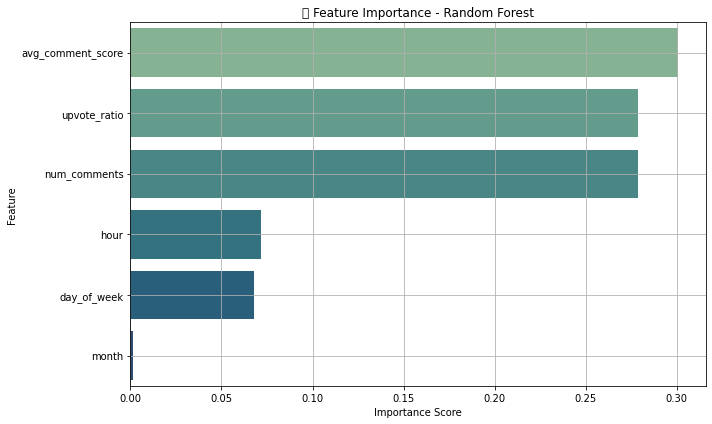

<Figure size 432x288 with 0 Axes>

In [0]:
# Required imports
import tempfile
import mlflow

# ✅ Your feature columns (should match training)
feature_cols = ['hour', 'day_of_week', 'month', 'num_comments', 'upvote_ratio', 'avg_comment_score']

# ✅ Extract the trained Random Forest model from the pipeline
rf_model = model.stages[-1]  # Last stage is RandomForestRegressor

# ✅ Get the feature importances
importances = rf_model.featureImportances.toArray()

# ✅ Create a DataFrame for plotting
feature_importance_df = pd.DataFrame({
    "feature": feature_cols,
    "importance": importances
}).sort_values(by="importance", ascending=False)

# ✅ Plot the feature importances
plt.figure(figsize=(10, 6))
sns.barplot(data=feature_importance_df, x="importance", y="feature", palette="crest")
plt.title("🌲 Feature Importance - Random Forest")
plt.xlabel("Importance Score")
plt.ylabel("Feature")
plt.grid(True)
plt.tight_layout()
plt.show()

# ✅ (Optional) Log the plot as artifact in MLflow
with tempfile.NamedTemporaryFile(suffix=".png", delete=False) as tmp:
    plt.savefig(tmp.name)
    mlflow.log_artifact(tmp.name, "feature_importance_plot")

## Performance Optimization with Partitioning  
In this section, we demonstrate how partitioning in Spark can significantly improve the performance of data transformations and storage operations. Using our Reddit engagement dataset, we compare baseline aggregation performance with repartitioned and coalesced data, and show how partitioning by relevant columns (like `hour` or `month`) leads to faster computation and more efficient disk writes.


In [0]:
from pyspark.sql.functions import col, month
import time

# 1. Baseline aggregation (no partitioning)
start = time.time()
df_cleaned.groupBy("hour").agg({"engagement_metric": "avg"}).collect()
print("⏱️ Baseline (no partitioning):", time.time() - start)

# 2. Repartition by 'hour' (distributes data better across workers)
df_repart = df_cleaned.repartition(24, "hour")

start = time.time()
df_repart.groupBy("hour").agg({"engagement_metric": "avg"}).collect()
print("⏱️ Repartitioned by hour:", time.time() - start)

# 3. Coalesce to reduce partitions for efficient write
df_coalesced = df_repart.coalesce(4)

# 4. Add a 'month' column if not already present
if "month" not in df_coalesced.columns:
    df_coalesced = df_coalesced.withColumn("month", col("month").cast("int"))  # Or derive it from a timestamp if needed

# 5. Write to disk in Parquet format, partitioned by month
output_path = "output/partitioned_reddit_data"

df_coalesced.write.mode("overwrite") \
    .partitionBy("month") \
    .parquet(output_path)

print(f"Partitioned data written to: {output_path}")

⏱️ Baseline (no partitioning): 1.160043716430664
⏱️ Repartitioned by hour: 1.0523333549499512
Partitioned data written to: output/partitioned_reddit_data


In [0]:
import time

# ✅ Step 1: Baseline Join (no partitioning)
start = time.time()
df_joined_baseline = df_post_reddit.join(df_comments_agg, on="post_id", how="left")
df_joined_baseline.count()  # trigger the join
print("⏱️ Baseline join time:", time.time() - start)

# ✅ Step 2: Repartition both sides on the join key
df_post_part = df_post_reddit.repartition("post_id")
df_comm_part = df_comments_agg.repartition("post_id")

start = time.time()
df_joined_partitioned = df_post_part.join(df_comm_part, on="post_id", how="left")
df_joined_partitioned.count()  # trigger the join
print("⏱️ Repartitioned join time:", time.time() - start)

⏱️ Baseline join time: 0.6358914375305176
⏱️ Repartitioned join time: 0.40420055389404297
